In [1]:
include("includes.jl");

In [43]:
Θ₀ = [5*pi/180, 0]
function dΘ(g)
    Θ -> [Θ[2], -g*sin(Θ[1])/7.5]
end

function log_likelihood(data)
    g -> let 
        g = isa(g, Array) ? g[1] : g
        Gg = rk4s(dΘ(g), Θ₀, [0; data], 0.01) 
        b = log.(abs.(0.01 ./ (0.01 + Gg[2:end,1]))).^2
        sum(b)/0.5
    end
end
 

log_likelihood (generic function with 1 method)

In [3]:
function simulate(n, g; τ = 0.01)
    n_times = 0
    times = zeros(n)

    t = 0
    Θ = Θ₀
    δΘ = dΘ(g)
    
    while n_times < n
        Θₙ = rk4(δΘ, Θ, τ)
        
        # if the angle has changed sign, we linearly approximate the intersection
        # of the trajectory with the x-axis
        if Θ[1] * Θₙ[1] <= 0
            t_intersect = t - τ*Θ[1]/(Θₙ[1] - Θ[1])
            n_times += 1
            times[n_times] = t_intersect
        end
        
        Θ = Θₙ
        t += τ
    end
    
    times
end

simulate (generic function with 1 method)

In [4]:
function GaussianMetropolisHastings(K, prior, ϕ, γ, x₀)
    X = zeros(K, length(x₀))
    Y = zeros(K, length(x₀))
    W = zeros(K)
    accepted = 0
    
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    ϕₓ = ϕ(x)
    
    for k=1:K
        y = x + rand(w)
        ϕₙ = ϕ(y)
        if rand() < min(1, (pdf(prior, y[1])/pdf(prior, x[1]))*exp(ϕₓ-ϕₙ))
            x = y
            ϕₓ = ϕₙ
            accepted += 1
        end
        
        W[k] = ϕₙ
        Y[k,:] = y
        X[k,:] = x
    end
    X, Y, exp.(-W), accepted
end

GaussianMetropolisHastings (generic function with 1 method)

In [34]:
function get_or_default(dict, key, default)
    haskey(dict, key) ? dict[key] : default
end

function test_mcmc(parameters)
    if haskey(parameters, :data)
        data = parameters[:data]
    else
        data_mean = get_or_default(parameters, :data_mean, 9.7935)
        data_var = get_or_default(parameters, :data_var, 0)
        data = simulate(12, data_mean)[2:end] + randn(11)*data_var
    end
    
    prior = get_or_default(parameters, :prior, Uniform(0,20))
    x₀ = get_or_default(parameters, :x₀, rand(prior, 1))
    
    mcmc_var   = get_or_default(parameters, :mcmc_var, 0.025)
    mcmc_steps = get_or_default(parameters, :mcmc_steps, 10000)
    burnin     = get_or_default(parameters, :burnin, 0)
    
    likelihood = log_likelihood(data)

    X,Y,W,a = GaussianMetropolisHastings(mcmc_steps, prior, likelihood, mcmc_var, x₀)
    X = X[burnin+1:end]
    Y = Y[burnin+1:end]
    W = W[burnin+1:end]
    
    data, (X,Y,W,a)
end

test_mcmc (generic function with 1 method)

In [26]:
function plot_loglikelihood(params)
    if haskey(params, :data)
        data = params[:data]
    elseif haskey(params, :value)
        data = simulate(12, params[:value])[2:end]
    end
    
    if haskey(params, :plot_mesh)
        mesh = params[:plot_mesh]
    elseif haskey(params, :plot_precision)
        mesh = linspace(5,14,params[:plot_precision])
    else
        mesh = linspace(5,14,100)
    end
    
    likelihood = log_likelihood(data)
    
    lhood = -likelihood.(mesh)
    elhood = exp.(lhood)
    elhood = elhood / sum(elhood)
    
    subplot(1,2,1)
    scatter(mesh, lhood,s=1)
    subplot(1,2,2)
    scatter(mesh, elhood,s=1)
end

plot_loglikelihood (generic function with 1 method)

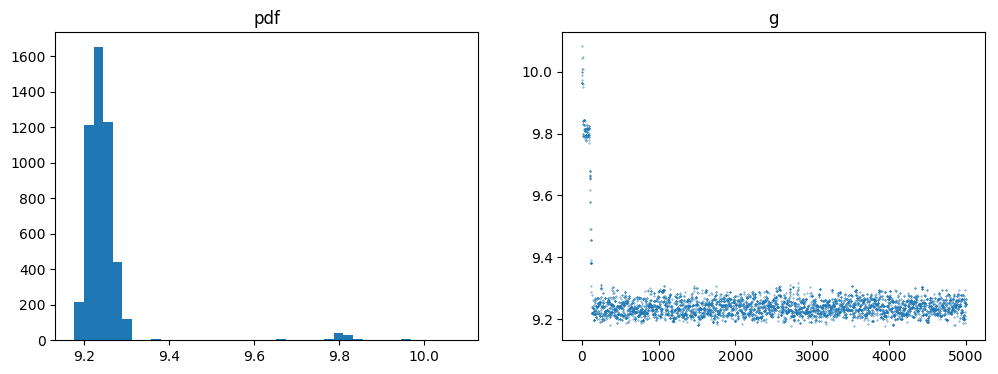

2479 / 5000 of the sampled particles were accepted (50.0%)
        
The expectation estimation is of 9.252104968160404


In [46]:
measurements, measurements_mask = load_experiments()
n_measurements = size(measurements)[1]


_,out = test_mcmc(Dict(
    :data       => measurements[1,:],
    :x₀         => 10,
    :prior      => Uniform(5,15),
    :mcmc_var   => 0.05,
    :mcmc_steps => 5000
));
plotMCMC(out)

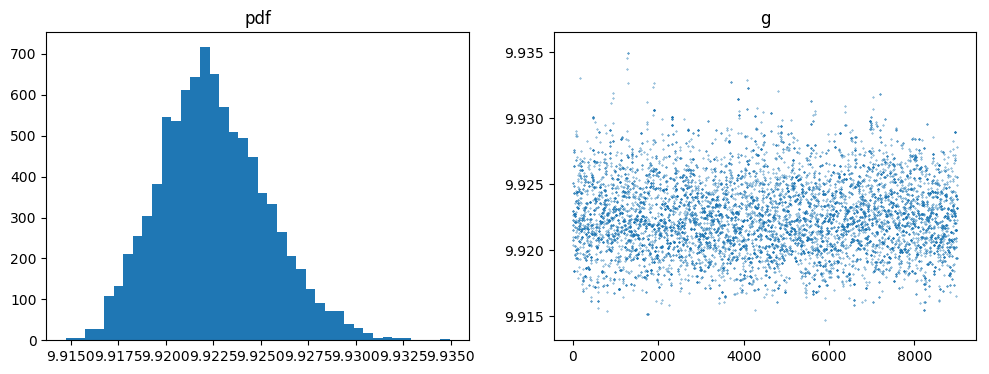

5287 / 9000 of the sampled particles were accepted (59.0%)
        
The expectation estimation is of 9.922522989506161


In [35]:
_,out = test_mcmc(Dict(
    :data       => load_flat_data(),
    :x₀         => 10,
    :prior      => Uniform(5,15),
    :mcmc_var   => 0.005,
    :mcmc_steps => 10000,
    :burnin     => 1000
));
plotMCMC(out)

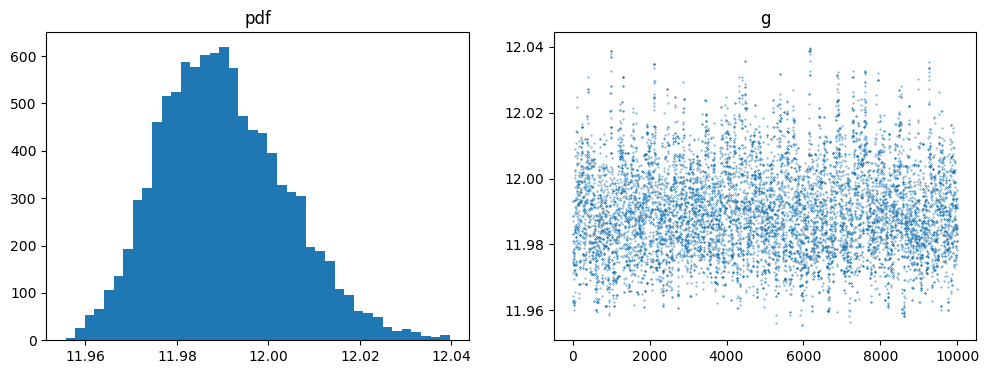

7714 / 10000 of the sampled particles were accepted (77.0%)
        
The expectation estimation is of 11.990118480761875


In [38]:
data_mean = 12
data, out = test_mcmc(Dict(
    :data_mean  => data_mean,
    :data_var   => 0.05,
    :x₀         => data_mean,
    :prior      => Uniform(5,15),
    :mcmc_var   => 0.01,
    :mcmc_steps => 10000
));
plotMCMC(out)

Interact.Slider{Int64}(25: "input-7" = 1 Int64 , "", 1, 1:58, "horizontal", true, "d", true)

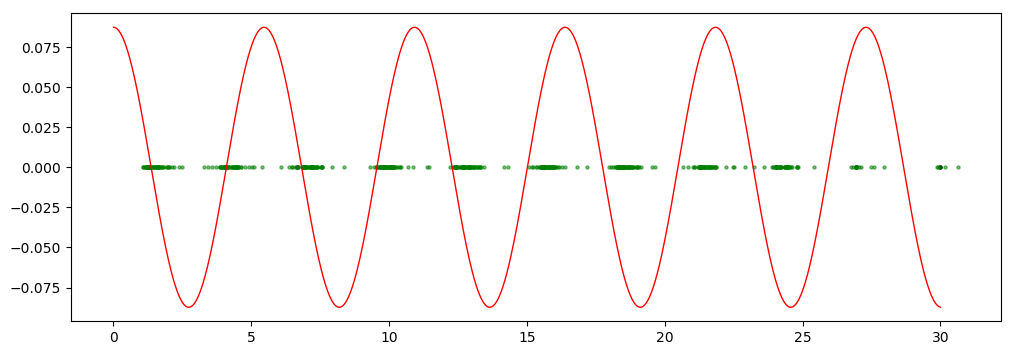

In [42]:
using Interact

flat_measurements = load_flat_data()
measurements, measurements_mask = load_experiments()
n_measurements = size(measurements)[1]

evaluation_mesh=collect(0:0.01:30)

Θ₀ = [8*pi/180, 0]
function dΘ(g,l)
    Θ -> [Θ[2], -g*sin(Θ[1])/l]
end

Gg1 = rk4s(dΘ(9.81,7.4), [5*pi/180, 0], evaluation_mesh, 0.01)[:,1]

fig=figure()
@manipulate for k=slider(1:n_measurements, value=1)
    withfig(fig) do
        plot(evaluation_mesh, Gg1, c="red", linewidth=1, label="g = 9.81, l = 7.4")
        scatter(measurements[k,:], zeros(measurements[k,:]), s=5,c="black",marker="o") 
        scatter(flat_measurements, zeros(flat_measurements),s=5, c="green", marker="o", alpha=0.5, label="measurements")
        
    end
end